#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [1]:
#$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [2]:
#import pandas as pd

#import zipfiles #i am not giving it a name cause i intend to use it only once

#zf = zipfile.ZipFile(fname)
#df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [3]:
# Loading the required libraries
%pylab inline
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import urllib2
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import zipfile
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

# Using the matplotlib customizing file
jsonFile = urllib2.urlopen('https://raw.githubusercontent.com/fedhere/PUI2015_fbianco/master/fbb_matplotlibrc.json')
s = json.load(jsonFile)
plt.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


C:\Users\kiran.pv\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Extracting postal codes from the geojson file

In [4]:
# Loading the geojson file
zipCodes = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zipCodes['postalCode'] = zipCodes['postalCode'].astype(int)
zipCodes.info()

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 12 columns):
@id               262 non-null object
BLDGpostalCode    262 non-null int64
CTY_FIPS          262 non-null object
OBJECTID          262 non-null int64
PO_NAME           262 non-null object
STATE             262 non-null object
ST_FIPS           262 non-null object
Shape_Area        262 non-null float64
Shape_Leng        262 non-null float64
borough           262 non-null object
geometry          262 non-null object
postalCode        262 non-null int32
dtypes: float64(2), int32(1), int64(2), object(7)
memory usage: 25.6+ KB


In [5]:
zipCodes.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.87440,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.91390,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6269333.41234,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,49418364.05770,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,69385865.59430,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [6]:
print len(zipCodes.postalCode.unique())

247


In [7]:
# Getting the unique zip values for merging business establishments
zips = pd.DataFrame(zipCodes.postalCode.unique())
zips.columns = ['postalCode']
zips['postalCode'] = zips['postalCode'].astype(int)
print zips.head()

   postalCode
0       11372
1       11004
2       11040
3       11426
4       11365


### Extracting census data for businesses and Merging with zips from geojson file

In [8]:
# Extracting data from business establishment zip files
finalData = zips

years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
         '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

for year in years:
    fname = 'zbp'+year+'totals.zip'
    
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    try:
        df = df[['zip','est']]
    except:
        df = df[['ZIP','EST']]
    df.columns = ['postalCode', 'est'+year]
    finalData = pd.merge(finalData,df,on='postalCode',how='left')

In [9]:
finalData.head()

,postalCode,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est04,est05,est06,est07,est08,est09,est10,est11,est12,est13
0,11372,1229,1236,1292,1309,1351,1376,1409,1408,1463,...,1554,1539,1527,1545,1538,1572,1629,1647,1724,1759
1,11004,194,188,176,192,194,186,189,204,214,...,226,225,226,238,227,233,229,222,241,241
2,11040,1422,1414,1335,1344,1344,1350,1350,1341,1398,...,1406,1441,1454,1488,1503,1475,1494,1488,1510,1539
3,11426,326,219,209,198,203,217,213,217,207,...,221,226,226,228,226,237,248,256,266,258
4,11365,492,476,483,522,509,519,553,574,574,...,599,604,608,617,616,628,643,677,679,714


In [10]:
finalData.shape

(247, 21)

### Preparing data for implementing clustering

In [11]:
# Converting the yearly data into matrix
data = finalData.dropna()
print data.shape

data = data.set_index(['postalCode'])
clusterData = data.as_matrix()

print clusterData.shape
print clusterData.shape[0]

(230, 21)
(230L, 20L)
230


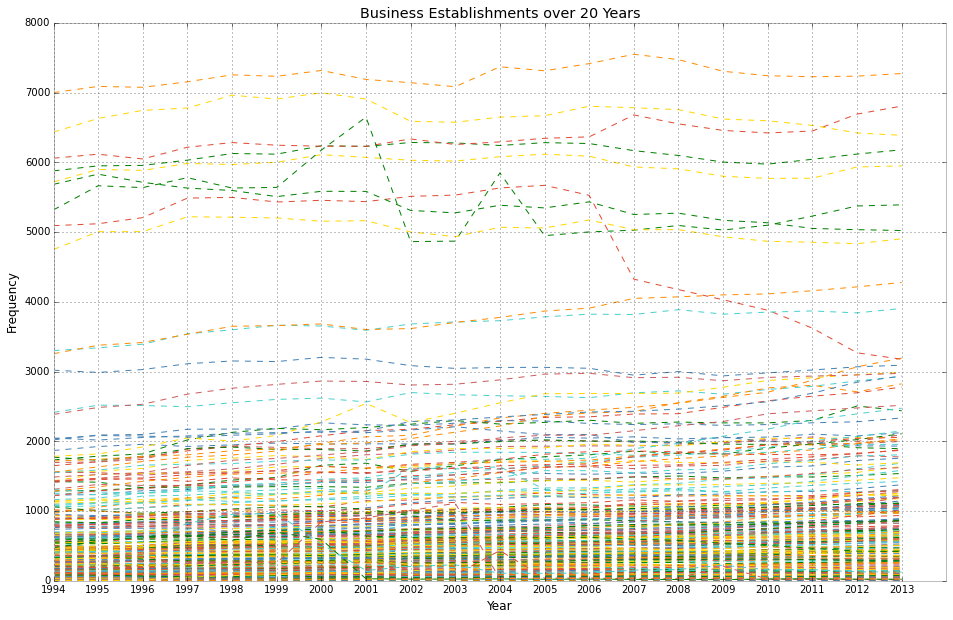

In [12]:
# Plotting all the years data for each zipcode
figure, ax = pl.subplots(figsize=(16,10))

for i in range(clusterData.shape[0]):
    ax.plot(clusterData[i], ls= '--', lw=1)
    
ax.set_title('Business Establishments over 20 Years')
ax.set_xticks(np.arange(20))
ax.set_xticklabels(1994 + np.arange(20))
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')

## KMeans Clustering

In [13]:
# Normalizing the data
vals = ((clusterData.T - clusterData.mean(1))/clusterData.std(1)).T
print vals.shape

(230L, 20L)


### Plotting cluster centroids for varying number of clusters

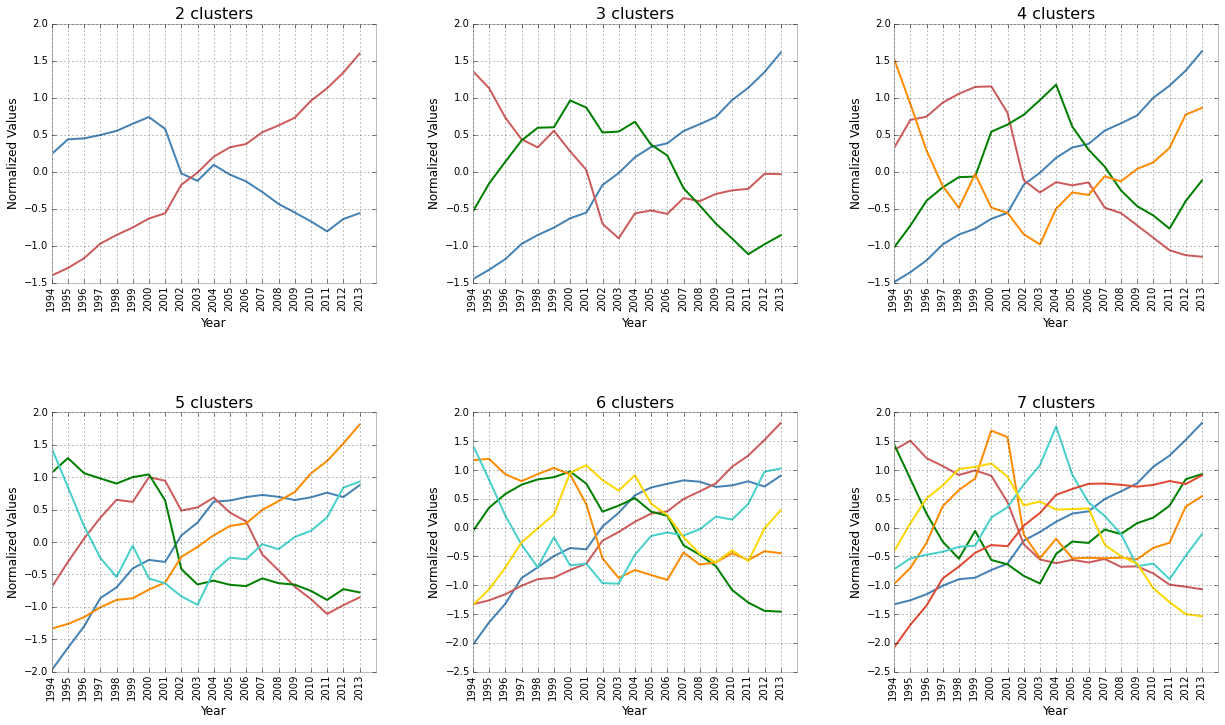

In [14]:
fig = pl.figure(figsize=(18,18))
for i in range(6):
    pl.subplot(2,3,i+1)
    n = i+2
    km = KMeans(n_clusters=n)
    km.fit(vals)
    centroids = km.cluster_centers_
    pl.plot(centroids.T)
    pl.title(str(n)+' clusters', fontsize = 16)
    pl.xticks(np.arange(20), 1994 + np.arange(20), rotation = 90)
    pl.xlabel('Year')
    pl.ylabel('Normalized Values')
pl.subplots_adjust(wspace=.3, hspace=0.5, left=0, right=0.9, top=0.5, bottom=0)

>**"From the above output, we can see that 4 clusters tend to capture the different trends present in the data more clearly. As the number increases further, we can notice that there are more minute differences in terms of the trends across the plots."**

In [15]:
# Using number of clusters as 7
km = KMeans(n_clusters=7)
km.fit(vals)
print km
kmlabels = km.labels_
kmcenters = km.cluster_centers_

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


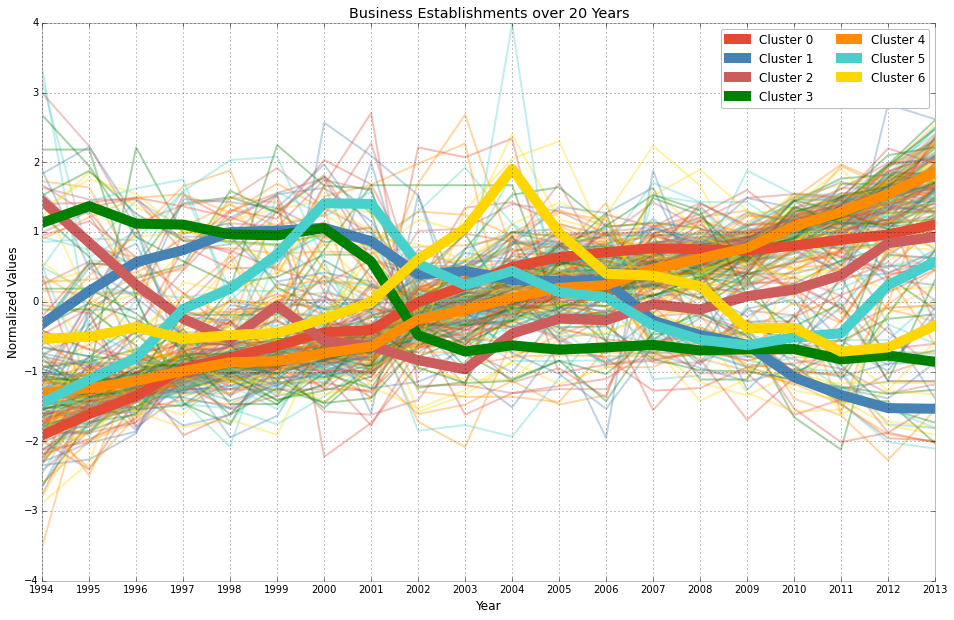

In [16]:
# Plotting all the values and respective centroid values for each of the cluster trends
figure, ax = pl.subplots(figsize=(16,10))
num_clusters = len(kmcenters)
    
for i in range(num_clusters):
    ax.plot(vals[kmlabels == i].transpose(), alpha=.35)

for i in range(num_clusters):
    ax.plot(kmcenters[i], linewidth=10, label='Cluster %s' % i)

ax.set_xlim([0,19])
ax.set_title('Business Establishments over 20 Years')
ax.set_xticks(np.arange(20))
ax.set_xticklabels(1994 + np.arange(20))
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Values')
ax.legend(ncol=2)

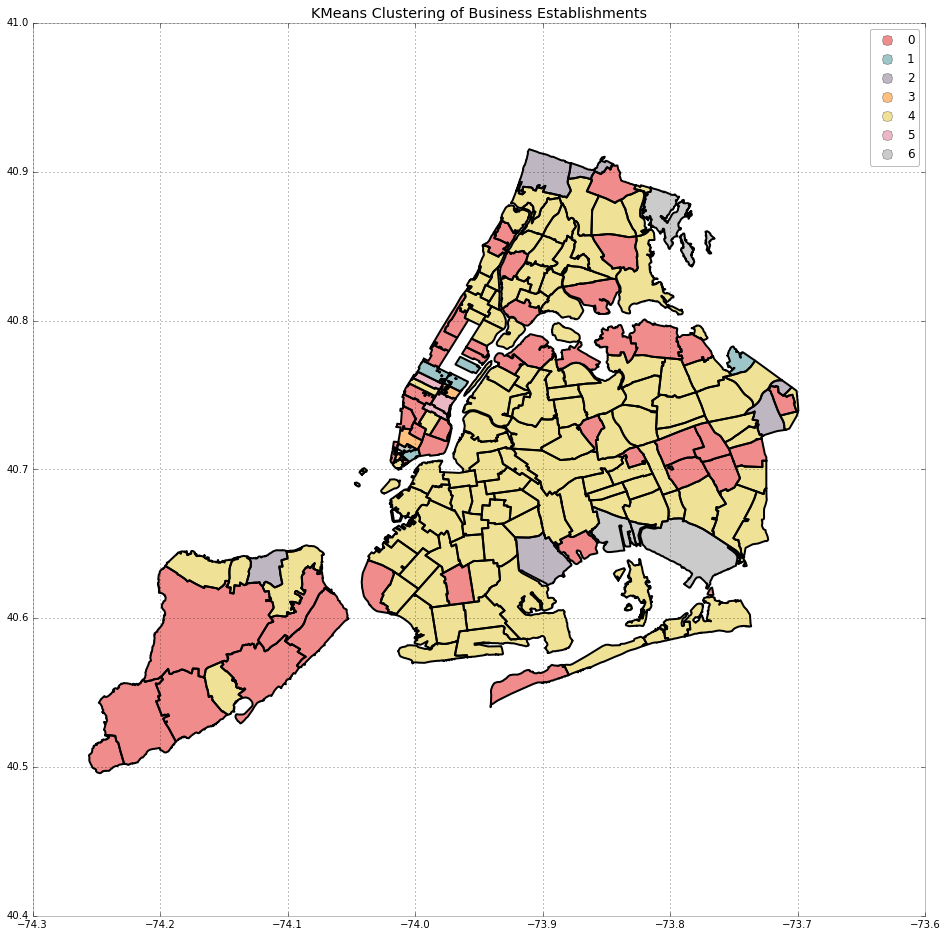

In [17]:
# Plotting the clustering ouput on NYC zipcode map
data['label'] = kmlabels
data['ZIP'] = data.index
merged = zipCodes.merge(data, left_on='postalCode', right_on='ZIP')
    
figure, ax = pl.subplots(figsize=(16,16))
merged.plot(axes=ax, column='label', legend=True, categorical=True)
ax.set_title('KMeans Clustering of Business Establishments')

# Affinity Propogation Clustering

In [18]:
# Using the affinity propagation algorithm
ap = AffinityPropagation(damping=0.99999999).fit(vals)
print ap
aplabels = ap.labels_
apcenters = ap.cluster_centers_

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.99999999, max_iter=200, preference=None, verbose=False)


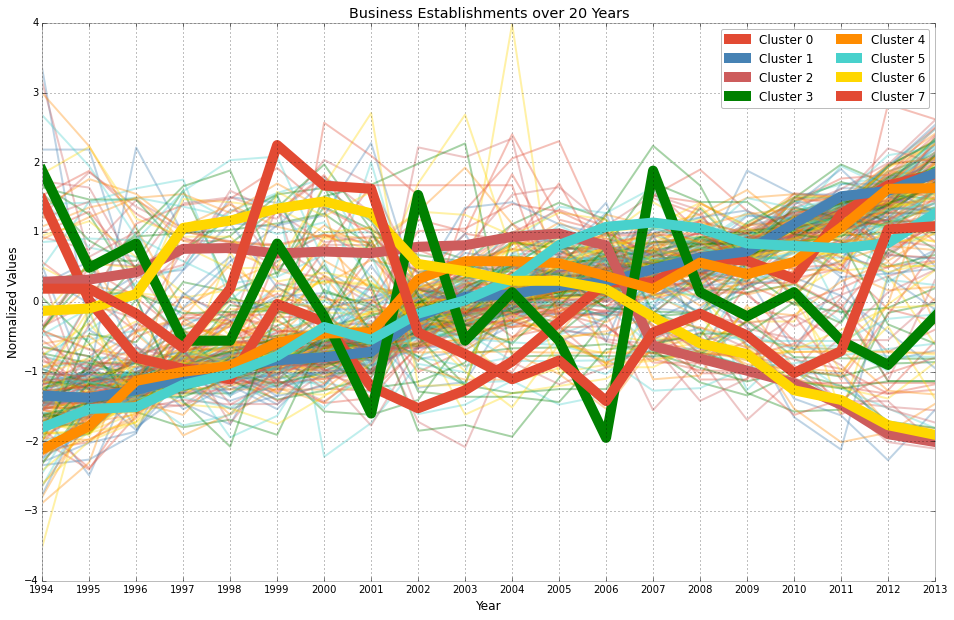

In [19]:
# Plotting all the values and respective centroid values for each of the cluster trends
figure, ax = pl.subplots(figsize=(16,10))
num_clusters = len(apcenters)
    
for i in range(num_clusters):
    ax.plot(vals[aplabels == i].transpose(), alpha=.35)

for i in range(num_clusters):
    ax.plot(apcenters[i], linewidth=10, label='Cluster %s' % i)

ax.set_xlim([0,19])
ax.set_title('Business Establishments over 20 Years')
ax.set_xticks(np.arange(20))
ax.set_xticklabels(1994 + np.arange(20))
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Values')
ax.legend(ncol=2)

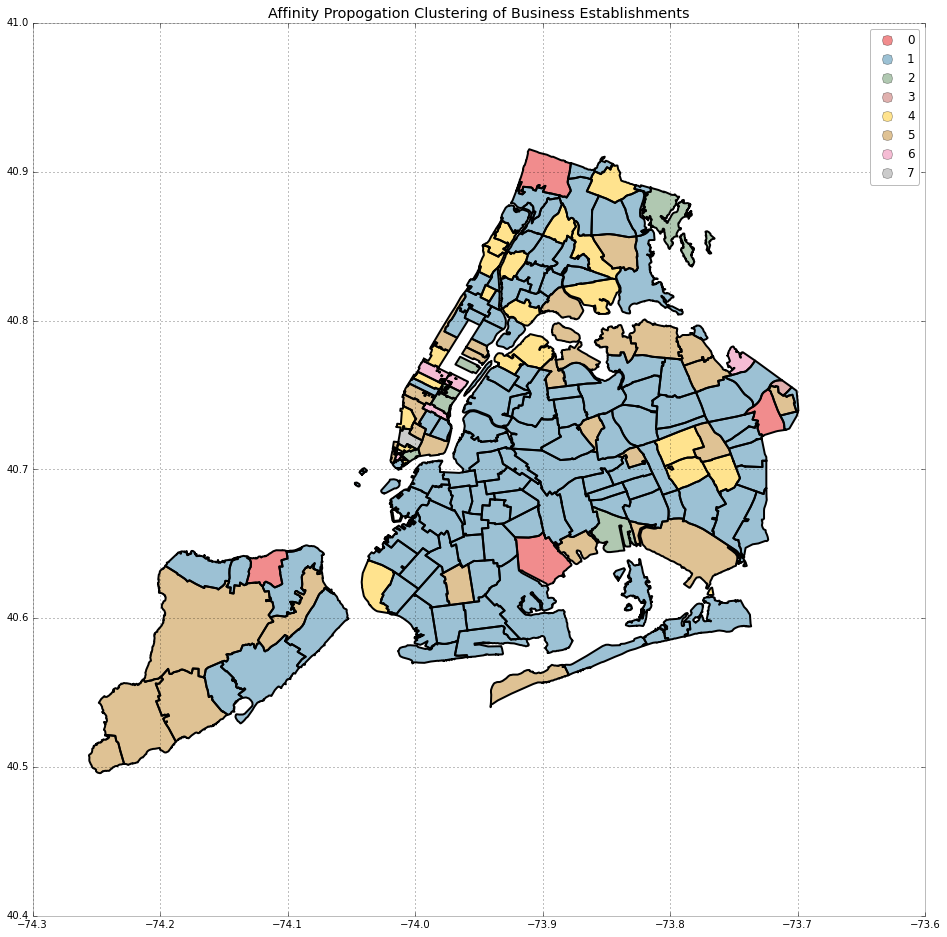

In [20]:
# Plotting the clustering ouput on NYC zipcode map
data['label1'] = aplabels
data['ZIP1'] = data.index
merged = zipCodes.merge(data, left_on='postalCode', right_on='ZIP1')
    
figure, ax = pl.subplots(figsize=(16,16))
merged.plot(axes=ax, column='label1', legend=True, categorical=True)
ax.set_title('Affinity Propogation Clustering of Business Establishments')

## Comparison of KMeans and AffinityPropogation Cluster Ouputs

>**"The final number of clusters for KMeans was 7 and for Affinity Propogation was 8. This input was subjectively selected for KMeans algorithm whereas it was dependent on the damping parameter for the Affinity Propogation algorithm. The damping parameter generally takes the value between 0.5 and 1, and higher value tend to provide us with lower number of clusters. For this assignment, I have chosen the damping value to be 0.99999 which resulted in 8 clusters. A slightly lower value of 0.9 was giving an output of ~30 clusters which would be too confusing to look at."**

>**"From the NYC zipcode level map, both the clustering algorithms tend to agree on the bigger clusters which is represented as cluster 4 for KMeans and cluster 1 for Affinity Propogation. Even the cluster across staten island tend to be similar by both the algorithms which are represented by cluster 0 and cluster 5 respectively across KMeans and Affinity Propogation outputs. One major thing to notice is that there are lot of cluster variations which are captured by both algorithms for Downtown Manhattan area probably driven by certain external market influences. Overall both algorithms tend to capture similar trends and there is not much differences in terms of their final output."**

>**"In terms of cluster algorithm comparison, in my opinion KMeans is more flexible to use as it lets us input the number of clusters as one of the parameters. This feature is not present in Affinity Propogation which might in somecases act as a disadvantage. This phenomenon is particularly true especially when the final requirement would require a lower number of clusters, then in those cases from these two algorithms, KMeans will proove to be more helpful."**